In [ ]:
" Guage is A = (0 , Bx , 0) ---> B = B along z direction"
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import sympy as sp

# Parameters
N = 16                # Lattice size 
B = 2 * 3.14159/N       # Magnetic field
a = 1                   # Lattice constant
t = 1                   # Hopping parameter

#  Indexing the sites
index = np.zeros(N)
for i in range(0, N, 1):
   index[i] = i
# print(index)
# Neighbour table to impliment periodic boundary condition
Lindex = np.zeros(N)
Rindex = np.zeros(N)
for i in range(0, N, 1):
    if i - 1 == -1 :
        left = N-1
    else :
        left = i - 1
    
    if i + 1 > N-1 :
        right = 0
    else :
        right = i + 1
        
    Lindex[i] = left
    Rindex[i] = right    
print(Lindex)   
print(Rindex)     

def H(kx, ky):
    Hij = np.zeros((N,N), dtype=np.complex128)
    for i in range(0,N):
        left, right = int(Lindex[i]), int(Rindex[i])  # Convert to integers
        Hij[i][i] = 2 * t * np.cos((a*ky) + (B*a*(i+1))) 
        Hij[left][i] = t * np.exp(1j * kx)
        Hij[right][i] = t * np.exp(-1j * kx)
    return Hij      
# print(H(0,5))  

# define the derivative of the hamiltonian (kx):
def H_dx(kx, ky):
    Hij = np.zeros((N,N), dtype=np.complex128)
    for i in range(0, N):
        left, right = int(Lindex[i]), int(Rindex[i])  # Convert to integers
        Hij[left][i] = 1j * t * np.exp(1j * kx)
        Hij[right][i] = - 1j * t * np.exp(-1j * kx)
    return Hij 
                
def H_dy(kx, ky):
    Hij = np.zeros((N,N), dtype=np.complex128)
    for i in range(0,N):
        Hij[i][i] = - 2 * a * t * np.sin(a*ky + B*a*(i+1)) 
    return Hij 

    
    

[15.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.  0.]


In [158]:
# Berry curvature calculation
grid_size = 200
kx_array = [(2 * 3.14159 * inc)/(N * grid_size) for inc in range(0, grid_size + 1)]
ky_array = [(2 * 3.14159 * inc)/(grid_size) for inc in range(0, grid_size + 1)]
# print(kx_array)

eta = 10**(-3)

def E_value(kx, ky):
    eigenvalues = np.linalg.eigvalsh(H(kx, ky))
    return eigenvalues

def sorted_kets(kx, ky):
    eigenvalues, eigenvectors = np.linalg.eigh(H(kx,ky))
    a = np.transpose(eigenvectors)
    return a

def b_curvature(kx, ky, band_index):
    berry_curvature = 0
    
    band_ev = E_value(kx, ky)[band_index]
    filtered_ev = [ev for ev in E_value(kx, ky) if ev != band_ev]
    band_ket = sorted_kets(kx, ky)[band_index]
    filtered_ket = [vec for index, vec in enumerate(sorted_kets(kx, ky)) if index != band_index]
    
    dh_x = H_dx(kx, ky)
    dh_y = H_dy(kx, ky)
    
    for i in range(0, len(filtered_ket)):
        berry_curvature += (np.dot(np.conj(band_ket), np.dot(dh_x, filtered_ket[i])) * np.dot(np.conj(filtered_ket[i]), np.dot(dh_y, band_ket)) - np.dot(np.conj(band_ket), np.dot(dh_y, filtered_ket[i])) * np.dot(np.conj(filtered_ket[i]), np.dot(dh_x, band_ket))) / ((band_ev - filtered_ev[i] + eta)**2)
    
    return -berry_curvature.imag

b_c_band = np.zeros((grid_size+1, grid_size+1))     

for i in range(0, len(kx_array)):
    for j in range(0, len(ky_array)):
        kx = kx_array[i]
        ky = ky_array[j]
        b_c_band[i][j] = E_value(kx, ky)[4]
        
        

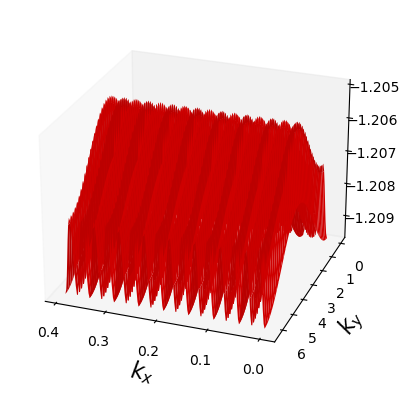

In [159]:
# Create a figure and a 3D axis
x, y = np.meshgrid(kx_array, ky_array)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.plot_surface(x, y,  b_c_band, color='red', linewidth=0.5,rstride=5, cstride=5)

# Set labels and title
ax.set_xlabel('$k_x$',fontsize = 16)
ax.set_ylabel('$k_y$',fontsize = 16)



# Remove grid lines
ax.grid(False)
 
ax.view_init(elev=  25, azim=110)
# Show the plot
plt.show()

In [149]:
# Band data
bands = []
for band_index in range(N):
    for kx in kx_array:
        for ky in ky_array:
            bands.append(E_value(kx, ky)[band_index])
            
berry_curvature = []
for band_index in range(N):
    for kx in kx_array:
        for ky in ky_array:
            berry_curvature.append(b_curvature(kx, ky, band_index))

In [171]:
Ef = [-5 + i/50 for i in range(501)]
kT = 0.00000001;

In [161]:
# Kubo formula implimentation
sigma = []
for fermi_energy in Ef:
    energies = []
    bc_list = []
    for i in range(len(bands)):
        if bands[i] <= fermi_energy:
            energies.append(bands[i])
            bc_list.append(berry_curvature[i])
    if energies != []:
        conductivity = 0
        for i in range(len(energies)):
            conductivity += bc_list[i]/(1 + np.exp((energies[i] - fermi_energy)/kT))
        sigma.append(-conductivity * (1/(2*3.14 * N)) * (2 * 3.14/(grid_size))**2)
    else:
        sigma.append(0)  # Append a default value if no tuples were selected


(-8.0, 8.0)

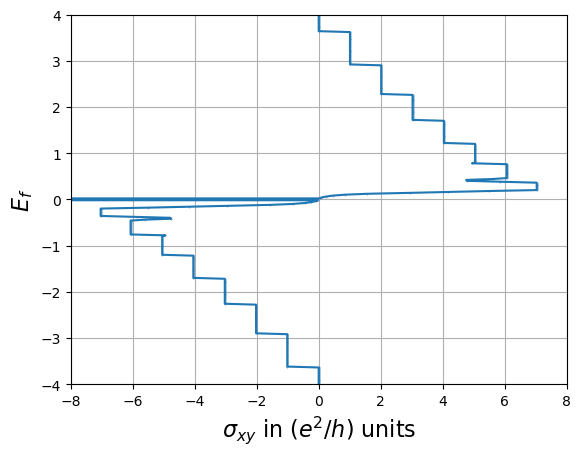

In [169]:
f = plt.figure();   
plt.plot( sigma, Ef,  marker='o', linestyle='-', markersize= 0.25 )
plt.grid()
plt.ylabel("$E_f$", fontsize=16); plt.axis('tight');
plt.xlabel("$\sigma_{xy}$ in ($e^2/h$) units", fontsize=16); plt.axis('tight');
plt.ylim(-4, 4)
plt.xlim(-8,8)

In [165]:
import csv

# Example data
data = []

for i in range(len(Ef)):
    data.append([sigma[i], Ef[i]])


In [167]:
# File path to save CSV
file_path = "/Users/satheeshdm/Desktop/January/MSc Thesis/squareinB.csv"

# Writing to CSV file
with open(file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(data)
